In [1]:
!nvidia-smi

Thu Jan 20 03:17:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 29%   35C    P8     1W / 250W |   7394MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1C:00.0 Off |                  N/A |
| 43%   

In [2]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.datasets import make_swiss_roll
from nits.model import *

device = 'cuda:7'

In [3]:
class MLP(nn.Module):
    def __init__(self, arch):
        super(MLP, self).__init__()
        self.layers = self.build_net(arch, name_str='d', linear_final_layer=True)
            
    def build_net(self, arch, name_str='', linear_final_layer=True):
        net = nn.ModuleList()
        for i, (a1, a2) in enumerate(zip(arch[:-1], arch[1:])):
            net.append(nn.Linear(a1, a2))
            
            # add nonlinearities
            if i < len(arch) - 2 or not linear_final_layer:
                net.append(nn.ReLU())
                
        return net

    def forward(self, x):
        y = x
        for l in self.layers:
            y = l(y)
        
        return y
    
class VAEPIN(nn.Module):
    def __init__(self, d, arch=[512, 512], pin_arch=[8, 8, 8, 1], constraint_type='neg_exp',
                 log_var_bias=-5., max_alpha=1., autoregressive=False):
        super(VAEPIN, self).__init__()
        self.d = d
        self.arch, self.pin_arch = arch, pin_arch
        self.constraint_type = constraint_type
        self.log_var_bias = log_var_bias
        self.max_alpha = max_alpha
        self.autoregressive = autoregressive
        
        self.register_buffer('start', torch.tensor([0.] * self.d).reshape(1, self.d))
        self.register_buffer('end', torch.tensor([1.] * self.d).reshape(1, self.d))
        
        # build PIN models
        
        final_constraint_type = 'softmax'
        if autoregressive:
            self.prior = ConditionalNITS(d=self.d, arch=[d] + pin_arch, start=0., end=1., 
                                        A_constraint=constraint_type, add_residual_connections=True,
                                        final_layer_constraint=final_constraint_type)
            self.posterior = ConditionalNITS(d=self.d, arch=[d] + pin_arch, start=0., end=1., 
                                        A_constraint=constraint_type, add_residual_connections=True,
                                        final_layer_constraint=final_constraint_type)
        else:
            self.prior = NITS(d=self.d, arch=[1] + pin_arch, start=0., end=1., 
                             A_constraint=constraint_type, add_residual_connections=True,
                             final_layer_constraint=final_constraint_type)
            self.posterior = NITS(d=self.d, arch=[1] + pin_arch, start=0., end=1., 
                             A_constraint=constraint_type, add_residual_connections=True,
                             final_layer_constraint=final_constraint_type)  
        
        self.nits_params = torch.nn.Parameter(torch.randn((1, self.nits.tot_params)))
                        
        # build FC layers
        self.pre_encoder = MLP(arch=arch + [2 * self.d])
        self.decoder = MLP(arch=[d] + arch[::-1])
        
    def parameters(self):
        for param in self.pre_encoder.parameters():
            yield param
            
        for param in self.decoder.parameters():
            yield param
            
        for param in [p for prior in self.priors for p in prior.parameters()]:
            yield param
                                        
    def sample_p_z(self, n):
        z = self.nits.sample(n, self.nits_params)
        
        return z
    
    def sample_p_x(self, n):
        z = self.sample_p_z(n)
        
        x_hat = self.decode(z)
        
        return x_hat
    
    def p_z(self, z):
        p_z = self.nits.pdf(z, self.nits_params)
        p_z = p_z.prod(axis=1).unsqueeze(-1)
            
        return p_z
    
    def get_mu_log_var(self, mu_log_var):
        mu, log_var = mu_log_var[:,:self.d].sigmoid(), mu_log_var[:,self.d:].tanh() + self.log_var_bias
        
        return mu, log_var
    
    def p_z_x(self, z, x, log_prob=True):
        mu, log_var = self.get_mu_log_var(self.pre_encoder(x))
        
        normal = torch.distributions.Normal(mu, (log_var / 2).exp())
        
        scale = normal.cdf(self.end) - normal.cdf(self.start)
                 
        if (scale < 1e-2).any():
            print('uh oh scale very small! scale: mu: std:', scale, mu, (log_var / 2).exp())
        
        # compute pdf, scaled by truncated normal
        if log_prob:
            p_z_x = (normal.log_prob(z) - scale.log()).sum(axis=1, keepdim=True)
        else:
            p_z_x = (normal.log_prob(z).exp() / scale).sum(axis=1, keepdim=True)
        
        return p_z_x

    def sample_from_unit_cube(self, n, mu, log_var):
        z = torch.zeros((n, self.d), device=mu.device) - 1.
        
        while torch.logical_or(z > 1., z < 0.).any():
            # sample candidates
            c = torch.randn((n, self.d), device=mu.device) * (log_var / 2).exp() + mu
            idx = torch.logical_or(z > 1., z < 0.).any(axis=1)
            
            z[idx] = c[idx]
            
        return z
            
    def encode(self, x):
        mu, log_var = self.get_mu_log_var(self.pre_encoder(x))
        
        z = self.sample_from_unit_cube(len(x), mu, log_var)
        
        return z
        
    def decode(self, z):
        x_hat = self.decoder(z)
        
        return x_hat
    
    def alpha(self, t):
        t = int(t / 2)
        return min(0. + t * 0.1, self.max_alpha)
    
    def train_model(self, x, epochs=100, print_every=20, lr=1e-3, batch_size=64):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        t = torch.tensor(0., device=x.device)

        sum_recon_loss = 0.
        sum_kl_loss = 0.

        for e in range(epochs):
            for i, x_ in enumerate(create_batcher(x, batch_size=batch_size)):
                optimizer.zero_grad()

                z = model.encode(x_)
                x_hat = model.decode(z)

                recon_loss = ((x_hat - x_) ** 2).sum()
                kl_loss = (model.p_z_x(z, x_, log_prob=True) - model.p_z(z).log()).sum()
                loss = recon_loss + self.alpha(round(e / print_every)) * kl_loss
                
                t += 1

                sum_kl_loss += kl_loss.detach().cpu().numpy()
                sum_recon_loss += recon_loss.detach().cpu().numpy()

                loss.backward()

                optimizer.step()

            if e and e % print_every == 0:
                kl_loss = sum_kl_loss / print_every / len(x)
                recon_loss = sum_recon_loss / print_every / len(x)
                print('kl_loss: {:.3f} | recon_loss: {:.3f} | alpha_t {:.3f}'.format(
                    kl_loss, recon_loss, self.alpha(e)))
                sum_kl_loss, sum_recon_loss = 0., 0.

def create_batcher(x, y=None, batch_size=1):
    idx = 0
    p = torch.randperm(len(x))
    x = x[p]
    
    if y is not None:
        y = y[p]
    
    while idx + batch_size < len(x):
        if y is None:
            yield x[idx:idx+batch_size]
        else:
            yield x[idx:idx+batch_size], y[idx:idx+batch_size]
        idx += batch_size
    else:
        if y is None:
            yield x[idx:]
        else:
            yield x[idx:], y[idx:]
        
def bisection_search(increasing_func, target, start, end, n_iter=20, eps=1e-3):
    query = (start + end) / 2
    result = increasing_func(query)
    
    if n_iter == 0:
        eps = (result - target).norm()
        if eps > 1e-2:
            print("bottomed out recursion depth, return best guess epsilon =", eps)
            raise ValueError("best guess epsilon too high!")
        print("bottomed out recursion depth, return best guess epsilon =", eps)
        return query
    elif (result - target).norm() < eps:
        return query
    elif result > target:
        return bisection_search(increasing_func, target, start, query, n_iter-1, eps)
    else:
        return bisection_search(increasing_func, target, query, end, n_iter-1, eps)
    
def plot_n(X, n):
    _, arr = plt.subplots(n, n)
    arr = arr.reshape(-1)
    X = np.random.permutation(X)
    for i, x in enumerate(X):
        if i == (n * n):
            break
        arr[i].imshow(x.reshape(28, 28), cmap='gray')
        arr[i].axis('off')
        
def random_project(X, dim=2):
    _, d = X.shape
    P = torch.randn((d, 2), device=X.device)
    U, _, _ = torch.linalg.svd(P, full_matrices=False)
    
    return X.mm(U)

def top_components(X, dim=2):
    U, _, _ = torch.linalg.svd(X, full_matrices=False)
    
    return U

def scatter(X, method='', **kwargs):
    if method == 'top_components':
        X = top_components(X)
    elif method == 'random_project':
        X = random_project(X)
       
    plt.figure()
    plt.scatter(X[:,0], X[:,1], **kwargs)

In [4]:
i1, i2 = 0, 1

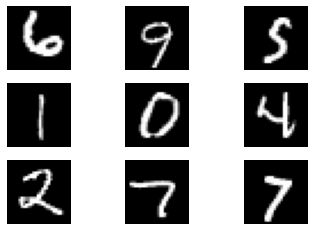

In [5]:
# %matplotlib inline

dataset = 'mnist'

if dataset == 'gaussian':
    n_gaussians = 2
    sig = 0.1
    torch.manual_seed(0)
    n, D, d = 1000, 2, 1#n_gaussians
    
    ns = [int(n / n_gaussians)] * (n_gaussians - 1)
    ns.append(n - np.sum(ns))
    
    mus = torch.randn((n_gaussians, D))
    mus_broadcast = mus.repeat_interleave(torch.tensor(ns), axis=0)
    
    x = torch.randn((n, D)) * sig + mus_broadcast
    
    y = torch.cat([torch.ones(n, 1) * i for i, n in enumerate(ns)], axis=0).to(device)

    # normalize
    x = (x - x.min(axis=0)[0][None,:]) / (x.max(axis=0)[0][None,:] - x.min(axis=0)[0][None,:])
    
    scatter(x.cpu(), c=y.cpu())
    n_classes = n_gaussians
elif dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = torch.tensor(x_train), torch.tensor(x_test)
    y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)
    x = torch.cat([x_train, x_test], axis=0).reshape(-1, 784).float() / 255.
    y = torch.cat([y_train, y_test], axis=0)
    
    n, D, d = len(x), 784, 2
    
    plot_n(x, n=3)
    
    n_classes = 10
    
x, y = x.to(device), y.to(device)

In [6]:
model = VAEPIN(d=d, arch=[D, 256, 512], 
               pin_arch=[32, 16, 8, 1], 
               constraint_type='neg_exp',
               log_var_bias=-7.,
               max_alpha=10.,
               autoregressive=False).to(device)

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


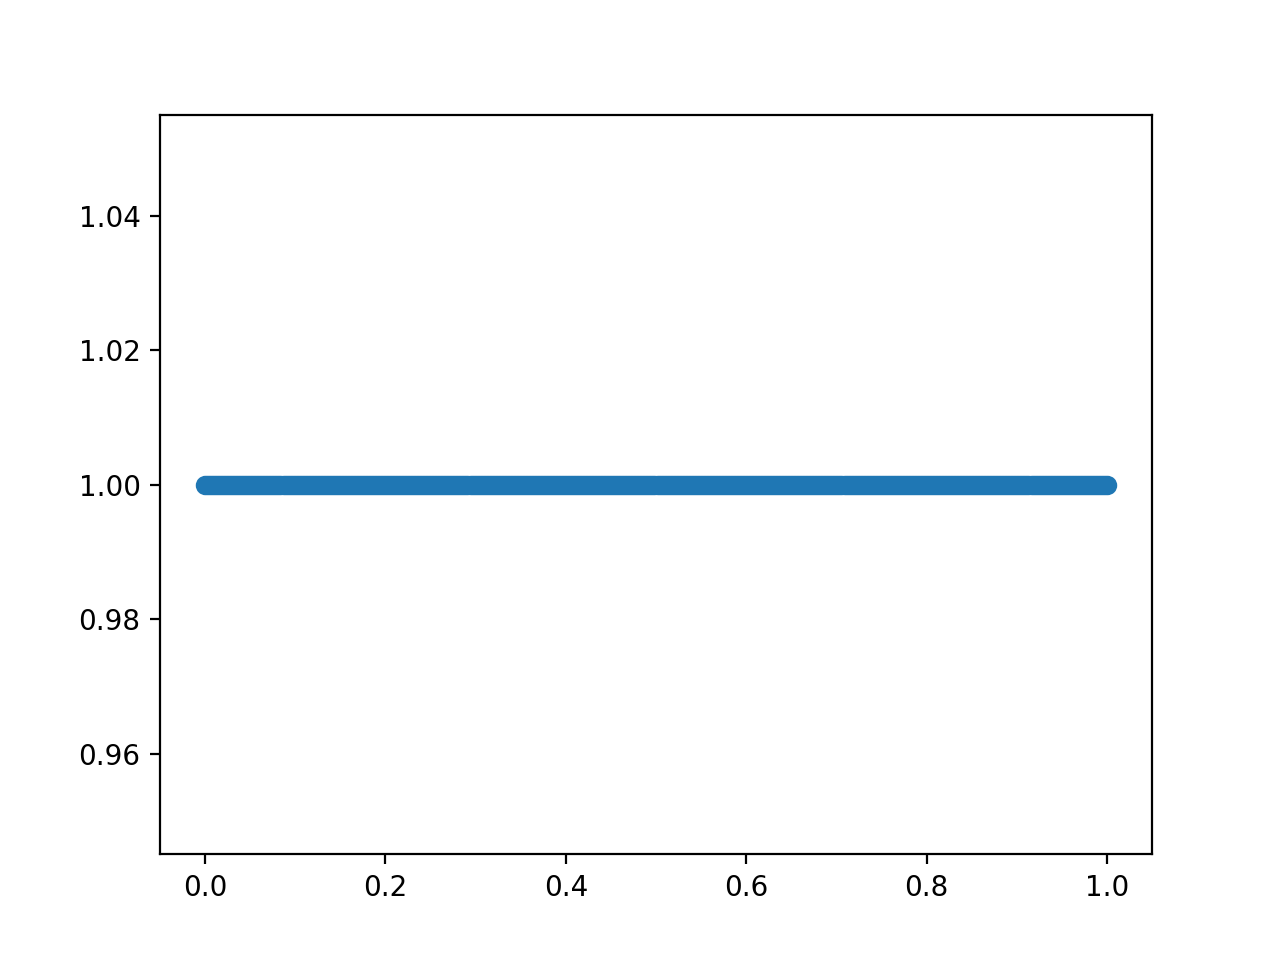

In [24]:
%matplotlib

x2 = torch.linspace(0, 1, 300, device='cpu').reshape(-1, 1).tile((1, d))

y2 = model.p_z(x2)
    
plt.scatter(x2[:,0].detach().cpu(), y2[:,0].detach().cpu())

In [16]:
model = model.to(device)
model.train_model(x, epochs=1000, print_every=5, lr=1e-3)

kl_loss: 5.238 | recon_loss: 28.499 | alpha_t 0.500
kl_loss: 5.237 | recon_loss: 28.479 | alpha_t 0.700
kl_loss: 5.236 | recon_loss: 28.449 | alpha_t 1.000
kl_loss: 5.234 | recon_loss: 28.428 | alpha_t 1.200
kl_loss: 5.237 | recon_loss: 28.419 | alpha_t 1.500
kl_loss: 5.238 | recon_loss: 28.388 | alpha_t 1.700
kl_loss: 5.238 | recon_loss: 28.383 | alpha_t 2.000
kl_loss: 5.239 | recon_loss: 28.356 | alpha_t 2.200
kl_loss: 5.234 | recon_loss: 28.329 | alpha_t 2.500
kl_loss: 5.235 | recon_loss: 28.330 | alpha_t 2.700
kl_loss: 5.232 | recon_loss: 28.316 | alpha_t 3.000
kl_loss: 5.235 | recon_loss: 28.314 | alpha_t 3.200
kl_loss: 5.233 | recon_loss: 28.294 | alpha_t 3.500
kl_loss: 5.236 | recon_loss: 28.292 | alpha_t 3.700
kl_loss: 5.231 | recon_loss: 28.292 | alpha_t 4.000
kl_loss: 5.230 | recon_loss: 28.261 | alpha_t 4.200
kl_loss: 5.235 | recon_loss: 28.246 | alpha_t 4.500
kl_loss: 5.231 | recon_loss: 28.252 | alpha_t 4.700
kl_loss: 5.231 | recon_loss: 28.257 | alpha_t 5.000
kl_loss: 5.2

kl_loss: 3.293 | recon_loss: 33.780 | alpha_t 10.000
kl_loss: 3.291 | recon_loss: 33.770 | alpha_t 10.000
kl_loss: 3.290 | recon_loss: 33.774 | alpha_t 10.000
kl_loss: 3.288 | recon_loss: 33.803 | alpha_t 10.000
kl_loss: 3.289 | recon_loss: 33.810 | alpha_t 10.000
kl_loss: 3.288 | recon_loss: 33.790 | alpha_t 10.000
kl_loss: 3.285 | recon_loss: 33.796 | alpha_t 10.000
kl_loss: 3.287 | recon_loss: 33.782 | alpha_t 10.000
kl_loss: 3.288 | recon_loss: 33.785 | alpha_t 10.000
kl_loss: 3.284 | recon_loss: 33.800 | alpha_t 10.000
kl_loss: 3.284 | recon_loss: 33.791 | alpha_t 10.000
kl_loss: 3.284 | recon_loss: 33.800 | alpha_t 10.000
kl_loss: 3.282 | recon_loss: 33.824 | alpha_t 10.000
kl_loss: 3.281 | recon_loss: 33.817 | alpha_t 10.000
kl_loss: 3.284 | recon_loss: 33.795 | alpha_t 10.000
kl_loss: 3.280 | recon_loss: 33.813 | alpha_t 10.000
kl_loss: 3.279 | recon_loss: 33.819 | alpha_t 10.000
kl_loss: 3.280 | recon_loss: 33.818 | alpha_t 10.000
kl_loss: 3.280 | recon_loss: 33.825 | alpha_t 

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


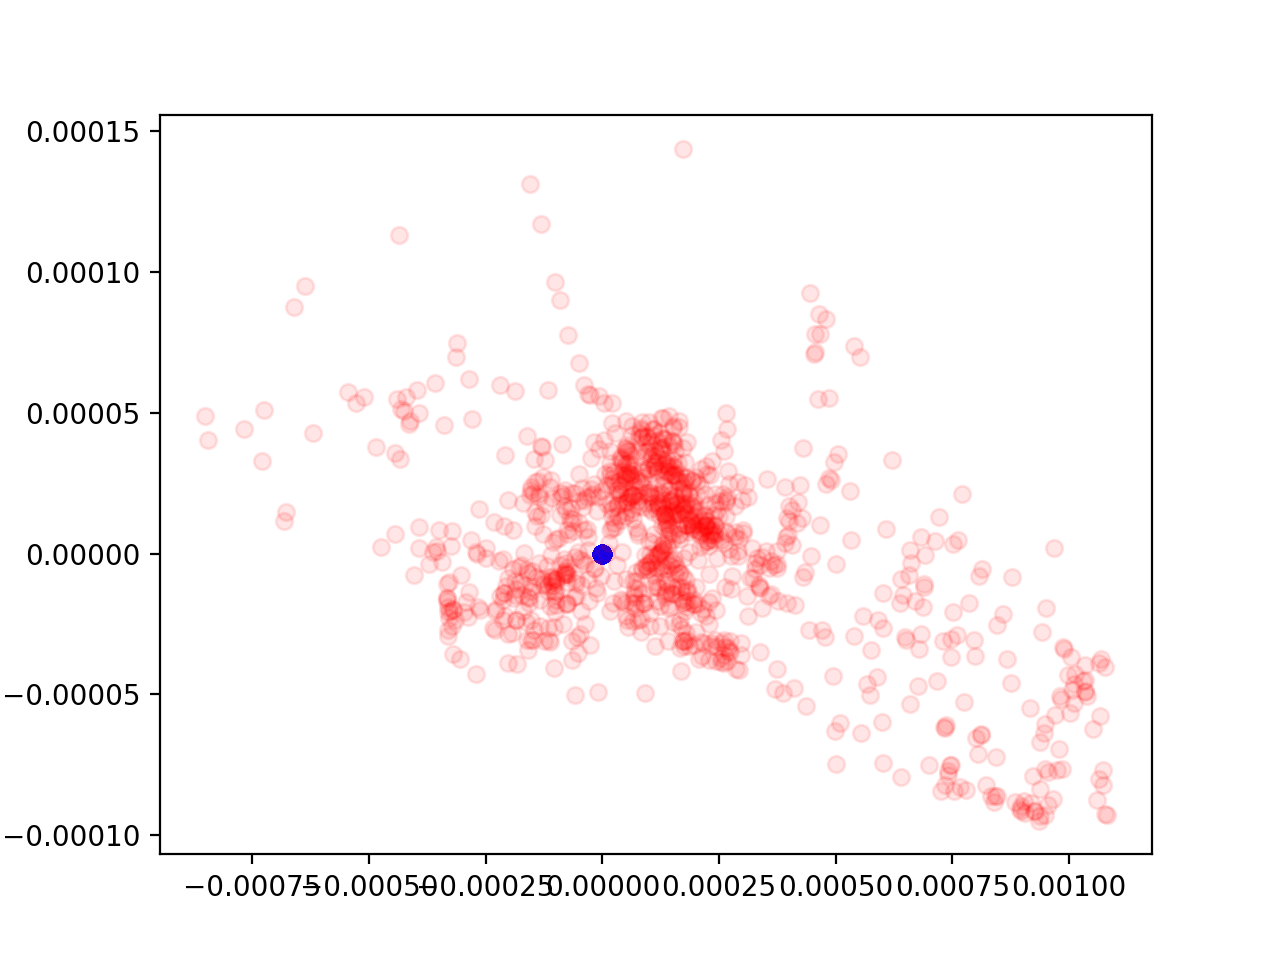

<IPython.core.display.Javascript object>


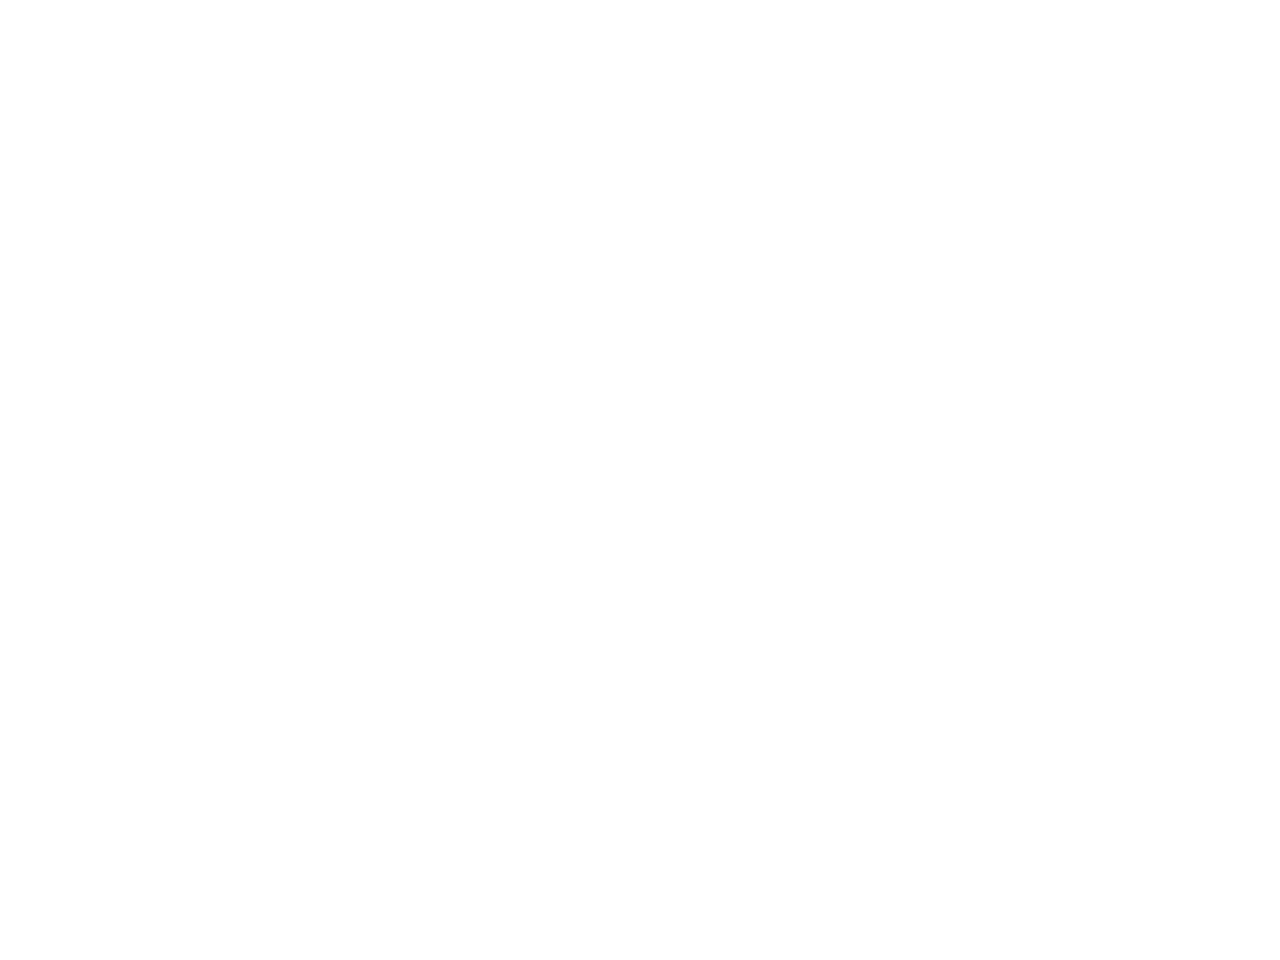

<IPython.core.display.Javascript object>


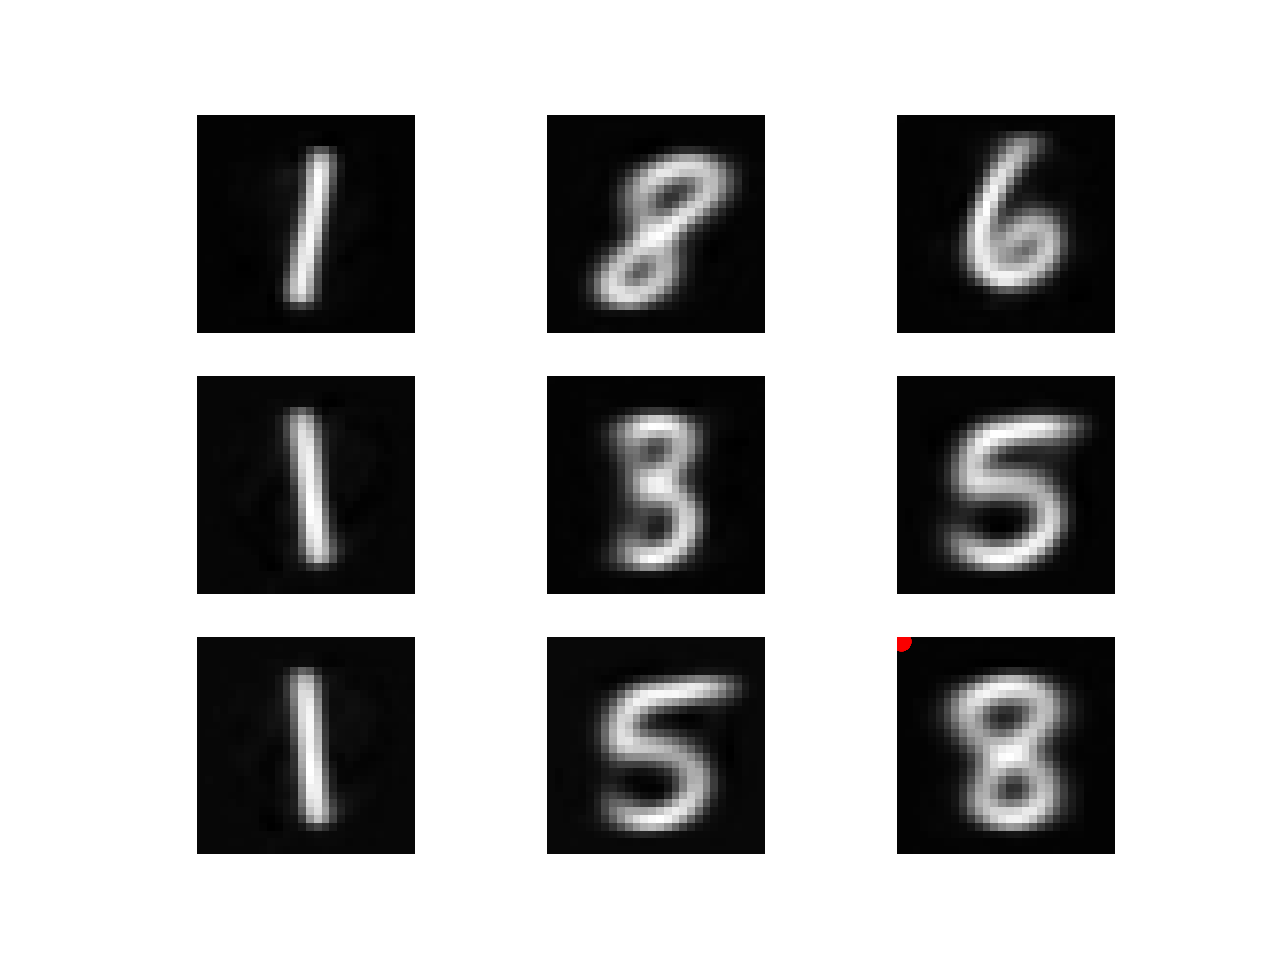

In [18]:
%matplotlib
model = model.to('cpu')
# RECONSTRUCTED DATA
x_hat = []

with torch.no_grad():
    for x_ in create_batcher(x.cpu(), batch_size=1024):
        z = model.encode(x_)
        x_hat.append(model.decode(z).cpu().detach())
        break
    
x_hat = torch.cat(x_hat, axis=0)

plt.scatter(x[:,i1].cpu(), x[:,i2].cpu(), c='blue', alpha=0.1)
plt.scatter(x_hat[:,i1], x_hat[:,i2], c='red', alpha=0.1)

plt.figure()

plot_n(x_hat, n=3)

<IPython.core.display.Javascript object>


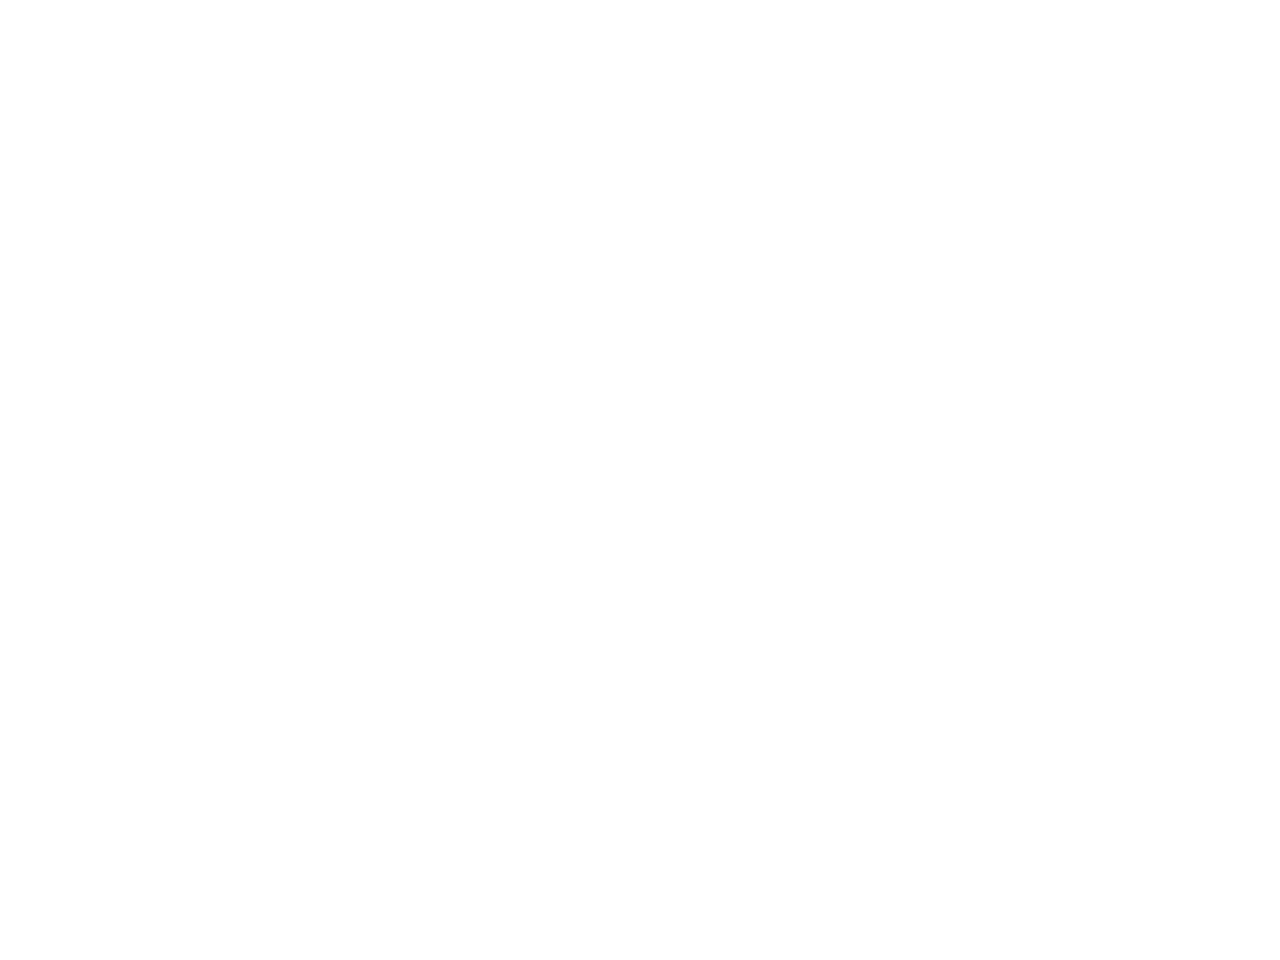

<IPython.core.display.Javascript object>


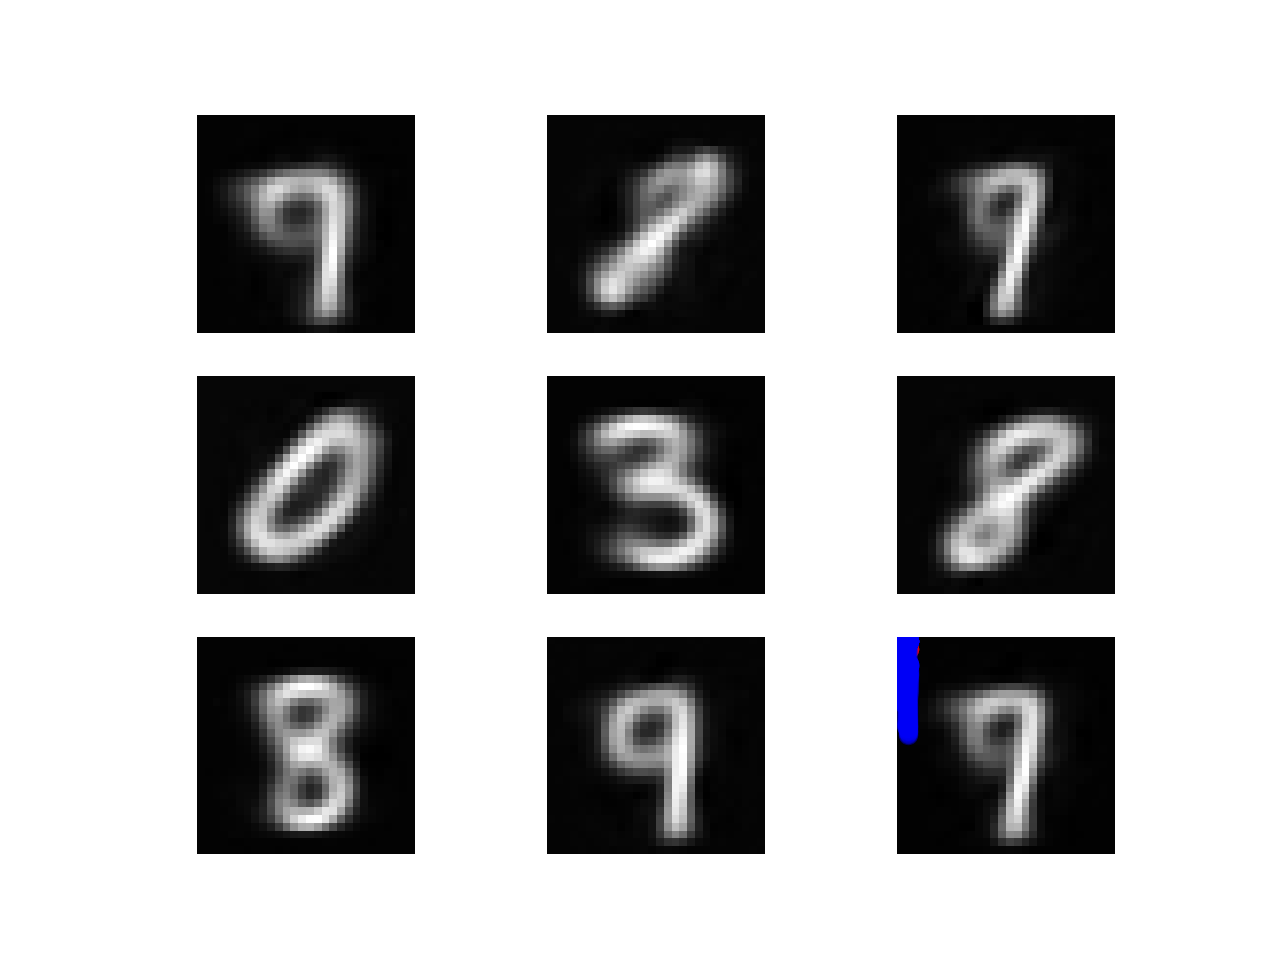

In [19]:
# %matplotlib inline
# GENERATED DATA
with torch.no_grad():
    x_sampled = model.sample_p_x(1000).detach().cpu().numpy()

plt.scatter(x[:,i1].cpu(), x[:,i2].cpu(), c='blue', alpha=0.2)
plt.scatter(x_sampled[:,i1], x_sampled[:,i2], c='red', alpha=0.2)

plt.figure()

plot_n(x_sampled, n=3)

In [20]:
# %matplotlib inline

model = model.to('cpu')

n_steps = 300

idx = 0

unif_1d_x = torch.linspace(0, 1, n_steps, device='cpu').reshape(-1, 1)
zeros = torch.zeros_like(unif_1d_x) + 0.0

unif_x = [zeros] * d
unif_x[idx] = unif_1d_x

unif_x = torch.cat(unif_x, axis=1)

y_prior = []
y_posteriors = [[] for n_ in range(n_classes)]

with torch.no_grad():
    for x_ in unif_x:
        y_prior.append(model.p_z(x_.reshape(1, d)))
        for n_ in range(n_classes):
            idx_ = n_ * int(n / n_classes)
            y_posteriors[n_].append(model.p_z_x(x_.reshape(1, d), x[idx_][None,:].cpu(), log_prob=False))

    y_prior = torch.cat(y_prior, axis=0)
    y_posteriors = [torch.cat(y_posterior, axis=0) for y_posterior in y_posteriors]
    
plt.scatter(unif_x[:,idx].detach().cpu(), y_prior[:,0].detach().cpu(), c='red', alpha=0.1)
for y_posterior in y_posteriors:
    plt.scatter(unif_x[:,idx].detach().cpu(), y_posterior[:,0].detach().cpu(), c='blue', alpha=0.1)

<IPython.core.display.Javascript object>


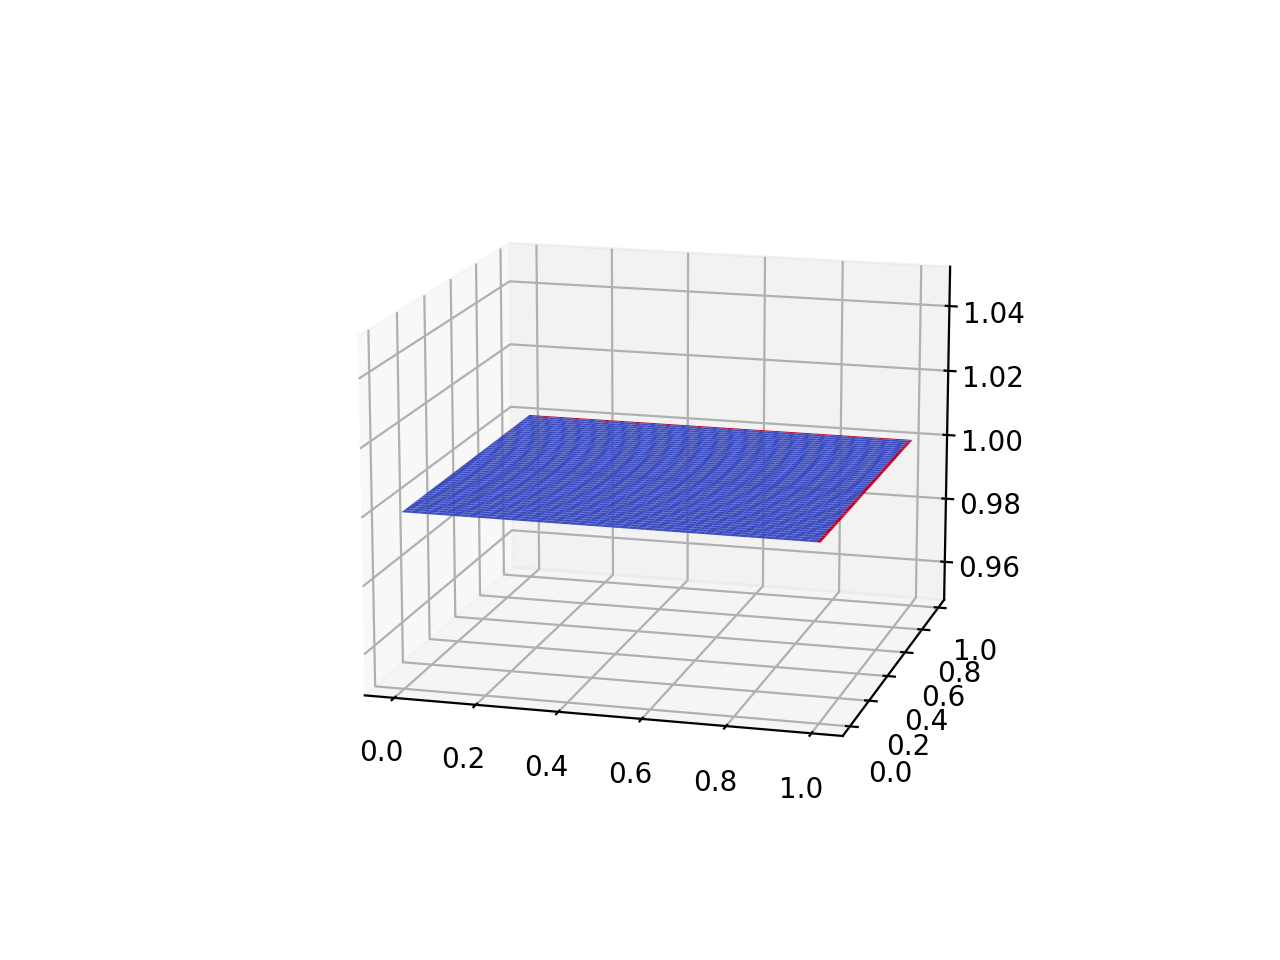

In [21]:
from matplotlib import cm
%matplotlib notebook

# plot prior surface
xs = torch.linspace(0, 1, steps=100, device='cpu')
ys = torch.linspace(0, 1, steps=100, device='cpu')

unif_x, unif_y = torch.meshgrid(xs, ys, indexing='xy')

unif_xy = torch.cat([unif_x.unsqueeze(-1), unif_y.unsqueeze(-1)], axis=2).reshape(-1, 2)

z = []

with torch.no_grad():
    z = model.p_z(unif_xy)
    
z = z.reshape(unif_x.shape)
    
ax = plt.axes(projection='3d')
ax.plot_surface(unif_x.cpu().numpy(), unif_y.cpu().numpy(), z.cpu().numpy(), cmap=cm.coolwarm)

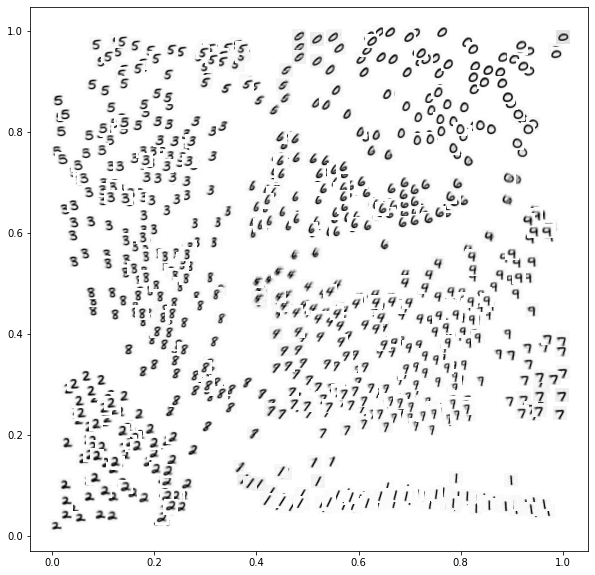

In [25]:
model = model.to('cpu')

%matplotlib inline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm, colors, colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

def imscatter(x, y, images, ax=None, zoom=1, colorby=None, color_mix=0.3, invert_images=False):
    if ax is None:
        ax = plt.gca()
        
    if invert_images:
        images = -images
        
    images = (images - images.min()) / (images.max() - images.min())
        
    if colorby is not None:
        assert len(colorby) == len(images)
        colorby = (colorby - colorby.min()) / (colorby.max() - colorby.min())
        if len(images.shape) == 3:
            images = images.reshape(-1, images.shape[1], images.shape[2], 1).tile((1, 1, 1, 4))
            images[:,:,:,3] = 1.
        norm = colors.Normalize(vmin=colorby.min(), vmax=colorby.max(), clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap='spring')
        a = color_mix
        
        images = images * (1 - a) + torch.tensor(mapper.to_rgba(colorby)).reshape(-1, 1, 1, 4) * a
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        colorbar.ColorbarBase(ax=cax, cmap=cm.get_cmap('spring'), values=sorted(colorby),
                                 orientation="vertical")

    artists = []
    for x0, y0, im0 in zip(x, y, images):
        im0 = OffsetImage(im0, zoom=zoom, cmap=plt.cm.gray_r)
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    
    return artists

p = torch.randperm(len(x))
x_subset = x[p][:1000].to('cpu')
with torch.no_grad():
    mu, log_var = model.get_mu_log_var(model.pre_encoder(x_subset.reshape(-1, 784)))
    x_hat = model.decode(mu).reshape(-1, 28, 28)

fig, ax = plt.subplots(figsize=(10, 10))
imscatter(mu[:,0], mu[:,1], x_hat.numpy(), ax=ax, zoom=0.5);

In [14]:
# plot prior surface
xs = torch.linspace(0, 1, steps=40, device='cpu')
ys = torch.linspace(0, 1, steps=40, device='cpu')

unif_x, unif_y = torch.meshgrid(xs, ys, indexing='xy')

unif_xy = torch.cat([unif_x.unsqueeze(-1), unif_y.unsqueeze(-1)], axis=2).reshape(-1, 2)

with torch.no_grad():
    x_hat = model.decode(unif_xy).cpu().reshape(-1, 28, 28)
    z = model.p_z(unif_xy).log().cpu()
    
z = z.reshape(unif_x.shape)
    
fig, ax = plt.subplots(figsize=(10, 10))
imscatter(unif_x.reshape(-1).numpy(), unif_y.reshape(-1).numpy(), x_hat, ax=ax, zoom=0.5, 
          colorby=z.reshape(-1), invert_images=True);

ValueError: Axis limits cannot be NaN or Inf

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 720x720 with 2 Axes>